In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 19.7MB/s 


In [3]:
import os
import numpy as np
import cv2
import scipy.io as sio
import PIL
import pydicom

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [4]:
train_dicom_dir = '/gdrive/My Drive/train/DICOM'
train_label_dir = '/gdrive/My Drive/train/Label'
test_dicom_dir = '/gdrive/My Drive/test/DICOM'

img_size = (512, 512)
num_classes = 2
batch_size = 2


train_dicom_paths = sorted(
    [
      os.path.join(path, filename) 
      for (path, dir, files) in os.walk(train_dicom_dir) 
      for filename in files 
      if os.path.splitext(filename)[-1] == '.dcm'
  ]
)

print('train DICOM :', len(train_dicom_paths), 'sets')


train_label_paths = sorted(
    [
      os.path.join(path, filename) 
      for (path, dir, files) in os.walk(train_label_dir) 
      for filename in files 
      if os.path.splitext(filename)[-1] == '.png'
  ]
)

print('train Label :', len(train_label_paths), 'sets')


test_dicom_paths = sorted(
    [
      os.path.join(path, filename) 
      for (path, dir, files) in os.walk(test_dicom_dir) 
      for filename in files 
      if os.path.splitext(filename)[-1] == '.dcm'
  ]
)

print('test DICOM :', len(test_dicom_paths), 'sets')


for dicom_path, label_path in zip(train_dicom_paths[-10:], train_label_paths[-10:]):
    print(dicom_path, "|", label_path)

train DICOM : 2900 sets
train Label : 2900 sets
test DICOM : 242 sets
/gdrive/My Drive/train/DICOM/200225_Patient15_CT/10143.dcm | /gdrive/My Drive/train/Label/200225_Patient15_CT/10143.png
/gdrive/My Drive/train/DICOM/200225_Patient15_CT/10144.dcm | /gdrive/My Drive/train/Label/200225_Patient15_CT/10144.png
/gdrive/My Drive/train/DICOM/200225_Patient15_CT/10145.dcm | /gdrive/My Drive/train/Label/200225_Patient15_CT/10145.png
/gdrive/My Drive/train/DICOM/200225_Patient15_CT/10146.dcm | /gdrive/My Drive/train/Label/200225_Patient15_CT/10146.png
/gdrive/My Drive/train/DICOM/200225_Patient15_CT/10147.dcm | /gdrive/My Drive/train/Label/200225_Patient15_CT/10147.png
/gdrive/My Drive/train/DICOM/200225_Patient15_CT/10148.dcm | /gdrive/My Drive/train/Label/200225_Patient15_CT/10148.png
/gdrive/My Drive/train/DICOM/200225_Patient15_CT/10149.dcm | /gdrive/My Drive/train/Label/200225_Patient15_CT/10149.png
/gdrive/My Drive/train/DICOM/200225_Patient15_CT/10150.dcm | /gdrive/My Drive/train/Label/

In [ ]:
print(test_dicom_paths[0])

/gdrive/My Drive/test/DICOM/180509_SampleData_CT/CT0008.dcm


In [ ]:
# How to check if the code is running on GPU or CPU?

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14179698857938539941
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4528512364102691856
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [5]:
from tensorflow.keras.preprocessing.image import load_img

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(path, window_widht=400, window_level=60):    
    image_medical = pydicom.dcmread(path)
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = window_image(image_hu.copy(), window_level, window_widht)
    image_window_norm = resize_normalize(image_window)

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    return image_ths

In [6]:
# DataGenerator : path list를 참조해 image & label 불러와 batch로 반환
class DataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, batch_size, image_size, train_dicom_dir, train_label_dir):
        self.batch_size = batch_size
        self.image_size = image_size
        self.train_dicom_paths = train_dicom_dir
        self.train_label_paths = train_label_dir
    
    def __len__(self):
        return len(self.train_dicom_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_train_dicom_paths = self.train_dicom_paths[i : i + self.batch_size]
        batch_train_label_paths = self.train_label_paths[i : i + self.batch_size]
        
        x = np.zeros((batch_size,) + self.image_size + (3, ), dtype='float32')
        for j, path in enumerate(batch_train_dicom_paths):
            # add augmenation dataset(*.jpg) ==> **지금은 X!**
            if path[-3:] == 'jpg':
                image = cv2.imread(path)
            else:
                image = read_dicom(path) * 255
            x[j] = image
        
        y = np.zeros((batch_size,) + self.image_size + (num_classes,), dtype='float32')
        #print(y.shape) ==> (2, 512, 512, 2)
        for j, path in enumerate(batch_train_label_paths):
            image = load_img(path, target_size=self.image_size, color_mode='grayscale')
            array = np.array(image) / 255 # 0과 255로 이루어진 (512, 512) 짜리 label 이미지
            num = np.unique(array) # [0 255]
            num = num.shape[0] # num.shape : (2, ) ==> num : 2
            y[j] = np.eye(num)[array.astype(int)] # y[0].shape : (512, 512, 2) ==> label이 2가지 이므로! (0, 255)
            # cf. 아래 np.eye() 사용법 참고!!
        return x, y

## Boolean Indexing
### np.eye(number of classes)[vector containing the labels(array)]
IndexError: **arrays used as indices must be of integer (or boolean) type**  
> 즉, IndexError: index 255 is out of bounds for axis 0 with size 2   
이 에러를 발생시킨 요인은, 뒤의 [ ] 안의 array! (**index**)  
  
> np.eye()를 indexing을 하기 위해 사용되는 np.array는 **int(0 or 1) or bool type**이어야 함!  
  
따라서 **label**의 요소값인 0과 255 대신 -> **0과 1**로 바꿔주기 위해, 다음과 같이 수정해줘야 한다.  
```py
array = np.array(image) / 255
...
y[j] = np.eye(num)[array.astype(int)]
```

In [ ]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [7]:
import random

val_samples = int(len(train_dicom_paths) * 0.1)
random.Random(1337).shuffle(train_dicom_paths)
random.Random(1337).shuffle(train_label_paths)

train_gen = DataGenerator(batch_size, img_size, train_dicom_paths[:-val_samples], train_label_paths[:-val_samples])
#print(train_gen[0][0][1].shape)
val_gen = DataGenerator(batch_size, img_size, train_dicom_paths[-val_samples:], train_label_paths[-val_samples:])

In [ ]:
print(train_gen[0][0][1].shape)

(512, 512, 3)


In [8]:
def make_colormask(class_data):
    img = PIL.Image.fromarray(class_data)

    mask_image = img.convert('RGBA')
    mask_pixel = mask_image.load()

    for i in range(mask_image.size[0]):
        for j in range(mask_image.size[1]):
            if mask_pixel[i, j] == (0, 0, 0, 255): # black(background)
                mask_pixel[i, j] = (0, 0, 0, 0);
            else:
                mask_pixel[i, j] = (255, 0, 0, 128) # white(body)
    return mask_image


def overlay_colormask_on_image(img, color_mask):
    return PIL.Image.alpha_composite(img.convert('RGBA'), color_mask) \
        .resize((img.size[0], img.size[1]), PIL.Image.ANTIALIAS)

In [ ]:
'''
sample_rows = 6
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))

for ((ax1, ax2), dcm_path, label_path) in zip(m_axs, train_dicom_paths, train_label_paths):
    dcm_image = PIL.Image.fromarray((read_dicom(dcm_path) * 255).astype('uint8'))
    label_image = PIL.Image.open(label_path)
    
    ax1.imshow(dcm_image)
    ax1.set_title('DICOM image')

    color_mask = make_colormask(np.array(label_image)) 
    overlay_image = overlay_colormask_on_image(dcm_image, color_mask)
    
    ax2.imshow(overlay_image)
    ax2.set_title('Label overlay image')
'''

"\nsample_rows = 6\nfig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))\n\nfor ((ax1, ax2), dcm_path, label_path) in zip(m_axs, train_dicom_paths, train_label_paths):\n    dcm_image = PIL.Image.fromarray((read_dicom(dcm_path) * 255).astype('uint8'))\n    label_image = PIL.Image.open(label_path)\n    \n    ax1.imshow(dcm_image)\n    ax1.set_title('DICOM image')\n\n    color_mask = make_colormask(np.array(label_image)) \n    overlay_image = overlay_colormask_on_image(dcm_image, color_mask)\n    \n    ax2.imshow(overlay_image)\n    ax2.set_title('Label overlay image')\n"

In [9]:
def get_model(img_size, num_classes):
    inputs = Input(shape=img_size + (3,))
    
    # 512
    down0a = Conv2D(16, (3, 3), padding='same')(inputs)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a = Conv2D(16, (3, 3), padding='same')(down0a)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    
    # 256
    down0 = Conv2D(32, (3, 3), padding='same')(down0a_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    
    # 128
    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    
    # 64
    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    
    # 32
    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    
    # 16
    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    
    # 8
    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    
    # center
    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    
    # 16
    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    
    # 32
    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    
    # 64
    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    
    # 128
    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    
    # 256
    up0a = UpSampling2D((2, 2))(up0)
    up0a = concatenate([down0a, up0a], axis=3)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    
    # 512
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0a)

    model = Model(inputs, outputs)
    return model

In [10]:
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
from tensorflow.keras import backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred):
    y_true_f = tf.cast(K.flatten(y_true), dtype='float32')
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
def dice_coef_multilabel(y_true, y_pred, num_labels = 2):
    dice = 0
    for index in range(num_labels):
        dice += (
        1 - dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        ) / num_labels
    return dice
def softmax_dice_loss(y_true, y_pred):
    index = tf.argmax(y_true, axis=-1)
    alpha = 1
    beta = 1
    return alpha * K.sparse_categorical_crossentropy(index, y_pred, from_logits=False) \
        + beta * dice_coef_multilabel(y_true, y_pred, 2)

In [ ]:
import tensorflow as tf 
print(tf.__version__) 
tf.test.is_gpu_available()

2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

* ETA (Estimating Travel Time) : 여정 시간을 예측하는 것 
* model.h5 : weight
* model.json : model

In [87]:
# compile model : 학습 과정 설정 
model.compile(optimizer='rmsprop', loss=softmax_dice_loss, metrics=['accuracy']) # metrics=['accuracy'] 추가해서 학습 및 테스트 시 활용하기!

# callback : 모델 학습 도중 정의한 조건을 만족했을 때 Model의 'weight' 값을 중간 저장 
# 중간에 memory overflow나 crash가 나더라도 다시 weight를 불러와서 학습을 이어나갈 수 있다
callbacks = [
    tensorflow.keras.callbacks.ModelCheckpoint('/gdrive/My Drive/model/model.h5', save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 20
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
1305/1305 [==============================] - 1560s 1s/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 2/20
1305/1305 [==============================] - 236s 181ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 3/20
1305/1305 [==============================] - 235s 180ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 4/20
1305/1305 [==============================] - 235s 180ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 5/20
1305/1305 [==============================] - 235s 180ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 6/20
1305/1305 [==============================] - 235s 180ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 7/20
1305/1305 [==============================] - 235s 180ms/step - loss: 0.0017 - accuracy: 0.9996 - val_lo

In [89]:
model_json = model.to_json()
with open("/gdrive/My Drive/model/model.json", "w") as json_file:
    json_file.write(model_json)

## compile & fit(train) 후 바로 evaluate(test)!
다양한 test set 폴더 경로 바꿔가면서 비교해보기! (이전 99.81, 96.15, 97.12 와 각각 비교해보기)  
> 이전에 저장한 model 불러온 후 다시 위에서 fit한거라서 loss는 더 낮고, accuracy는 더 높을 수도 있음!

In [100]:
# set test set path (only for new data - tcia)

test_dicom_dir = '/gdrive/My Drive/test/DICOM/'
test_label_dir = '/gdrive/My Drive/test/Label/'

test_dicom_paths = sorted(
    [
      os.path.join(path, filename) 
      for (path, dir, files) in os.walk(test_dicom_dir) 
      for filename in files 
      if os.path.splitext(filename)[-1] == '.dcm'
  ]
)

test_label_paths = sorted(
    [
      os.path.join(path, filename) 
      for (path, dir, files) in os.walk(test_label_dir) 
      for filename in files 
      if os.path.splitext(filename)[-1] == '.png'
  ]
)

print(len(test_dicom_paths))
print(len(test_label_paths))

178
178


In [101]:
test_gen = DataGenerator(batch_size, img_size, test_dicom_paths, test_label_paths)

loss, acc = model.evaluate(test_gen)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

89/89 [==============================] - 6s 63ms/step - loss: 1.5959 - accuracy: 0.9612
Restored model, accuracy: 96.12%


## load saved model

In [69]:
# 저장된 JSON 파일로 부터 모델 로드하기

from keras.models import model_from_json

json_file = open("/gdrive/My Drive/model/model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 
model = model_from_json(loaded_model_json)

In [70]:
# 로드한 모델에 Weight 로드하기

model.load_weights("/gdrive/My Drive/model/model.h5") 
print("Loaded model from disk")

Loaded model from disk


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## test (predict)

In [ ]:
from IPython.display import Image, display

preds = {}

for test_dicom_path in test_dicom_paths:
    test_image = read_dicom(test_dicom_path) * 255
    test_image = PIL.Image.fromarray(test_image.astype('uint8'))
    
    pred = model.predict(np.expand_dims(np.array(test_image), axis=0))
    class_data = np.argmax(pred.squeeze(), axis=-1).astype('uint8')
    
    #filename = os.path.basename(test_dicom_path) # 기본 이름 반환 (ex. CT0008.dcm)
    #preds[filename] = class_data
    preds[test_dicom_path] = class_data # 전체 경로로 수정! (key)

In [ ]:
print(len(preds))
print(preds['/gdrive/My Drive/test/DICOM/180509_SampleData_CT/CT0008.dcm'])
print(preds['/gdrive/My Drive/test/DICOM/180509_SampleData_CT/CT0008.dcm'].shape)
print(type(preds['/gdrive/My Drive/test/DICOM/180509_SampleData_CT/CT0008.dcm']))

242
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(512, 512)
<class 'numpy.ndarray'>


('/gdrive/My Drive/test/DICOM/04-04-2007-Chest-07990/1-01.dcm', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
***dcm_path*** : /gdrive/My Drive/test/DICOM/04-04-2007-Chest-07990/1-01.dcm
('/gdrive/My Drive/test/DICOM/04-04-2007-Chest-07990/1-02.dcm', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
***dcm_path*** : /gdrive/My Drive/test/DICOM/04-04-2007-Chest-07990/1-02.dcm
('/gdrive/My Drive/test/DICOM/04-04-2007-Chest-07990/1-03.dcm', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8

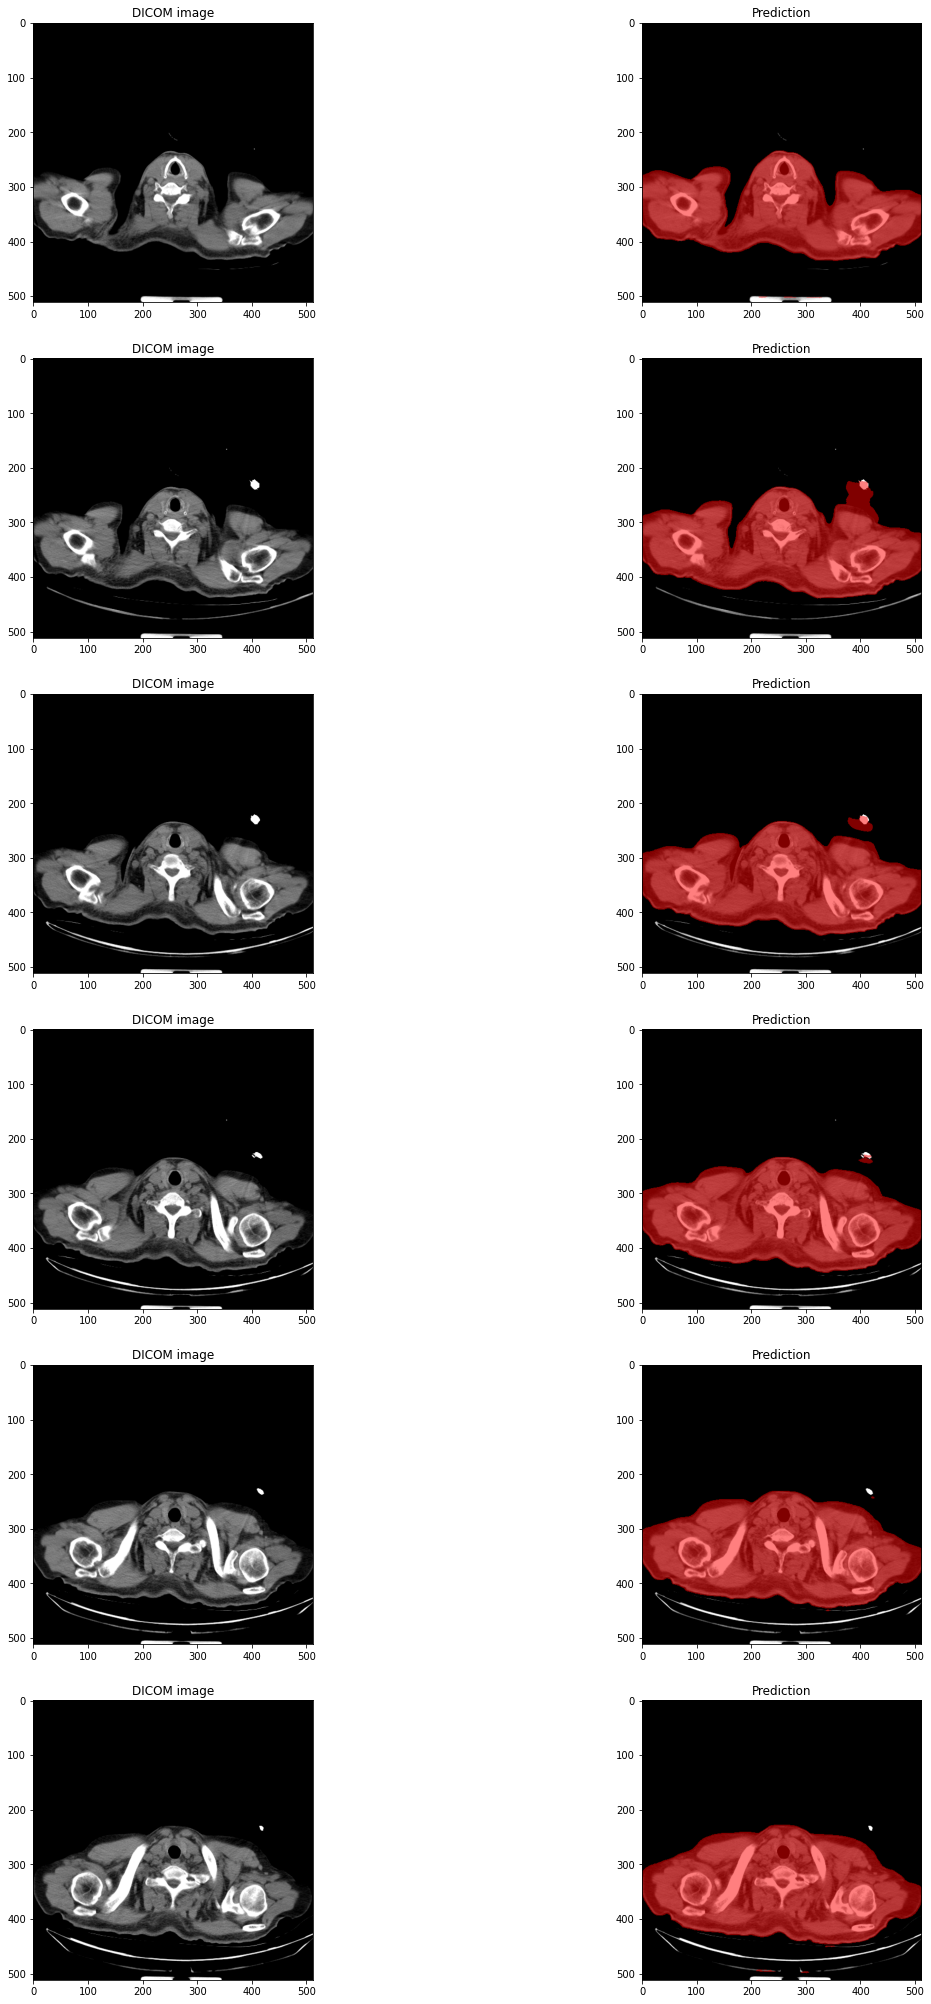

In [ ]:
sample_rows = 6
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))

for (ax1, ax2), (filename, pred) in zip(m_axs, preds.items()):
    print((filename, pred)) # dcm_path, array (size : (512, 512), value : (0 & 1))
    #dcm_path = os.path.join(test_dicom_dir, fielname)
    dcm_path = filename
    print('***dcm_path*** :', dcm_path)
    dcm_img = PIL.Image.fromarray((read_dicom(dcm_path) * 255).astype('uint8'))
    
    ax1.imshow(dcm_img)
    ax1.set_title('DICOM image')

    color_mask = make_colormask(pred) 
    overlay_img = overlay_colormask_on_image(dcm_img.convert('RGBA'), color_mask)
    #print(type(overlay_img), overlay_img.shape)
    
    ax2.imshow(overlay_img)
    ax2.set_title('Prediction')

## save PIL img

In [ ]:

print('test set num :', len(preds))

for (filename, pred) in preds.items():
    dcm_path = filename 
    #print(dcm_path) # /gdrive/My Drive/test/DICOM/180509_SampleData_CT/CT0008.dcm
    dcm_img = PIL.Image.fromarray((read_dicom(dcm_path) * 255).astype('uint8'))

    color_mask = make_colormask(pred) 
    overlay_img = overlay_colormask_on_image(dcm_img.convert('RGBA'), color_mask)
    overlay_img.save(dcm_path.replace('test/DICOM', 'result').replace('dcm', 'png')) # /gdrive/My Drive/result/180509_SampleData/CTCT0008.png

print('finish')


test set num : 242
finish


<hr>

## predict(test) & evaluate (accuracy)

### set path

In [64]:
# set test set path (only for new data - tcia)

test_dicom_dir = '/gdrive/My Drive/test/DICOM/04-04-2007-Chest-07990_wrong/'
test_label_dir = '/gdrive/My Drive/test/Label/04-04-2007-Chest-07990_wrong/'

test_dicom_paths = sorted(
    [
      os.path.join(path, filename) 
      for (path, dir, files) in os.walk(test_dicom_dir) 
      for filename in files 
      if os.path.splitext(filename)[-1] == '.dcm'
  ]
)

test_label_paths = sorted(
    [
      os.path.join(path, filename) 
      for (path, dir, files) in os.walk(test_label_dir) 
      for filename in files 
      if os.path.splitext(filename)[-1] == '.png'
  ]
)

print(len(test_dicom_paths))
print(len(test_label_paths))

27
27


## fail! 
직접 shape 맞춰서 list에 저장
* test dicom : (1, 512, 512, 3)
* test label : (512, 512)  
  
> model.evaluate(test_images, test_labels)

In [31]:
from IPython.display import Image, display

test_images = [] # dicom
test_labels = [] # label

#preds = {}

for test_dicom_path in test_dicom_paths:
    test_image = read_dicom(test_dicom_path) * 255 # (512, 512, 3)
    test_image = PIL.Image.fromarray(test_image.astype('uint8')) # (512, 512)
    
    test_images.append(np.expand_dims(np.array(test_image), axis=0))

    #pred = model.predict(np.expand_dims(np.array(test_image), axis=0)) # (1, 512, 512, 3)
    #class_data = np.argmax(pred.squeeze(), axis=-1).astype('uint8') # print(class_data.shape) : (512, 512)
    
    
    #filename = os.path.basename(test_dicom_path) # 기본 이름 반환 (ex. CT0008.dcm)
    #preds[filename] = class_data
    #preds[test_dicom_path] = class_data # 전체 경로로 수정! (key)
  


In [78]:
print(len(test_images))
print(test_images[0].shape)

64
(1, 512, 512, 3)


In [33]:
for test_label_path in test_label_paths:
    image = load_img(test_label_path, target_size=img_size, color_mode='grayscale')
    array = np.array(image) / 255 # 0과 255로 이루어진 (512, 512) 짜리 label 이미지
    test_labels.append(array)

In [34]:
print(len(test_labels))
print(test_labels[0].shape)

64
(512, 512)


In [36]:
model.compile(optimizer='rmsprop', loss=softmax_dice_loss) # loss : softmax_dice_loss (x)

loss, acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

ValueError: ignored

## success!
DataGenerator로 test_gen 만들기
> model.evaluate(test_gen)

In [71]:
test_gen = DataGenerator(batch_size, img_size, test_dicom_paths, test_label_paths)

In [84]:
model.compile(optimizer='rmsprop', loss=softmax_dice_loss, metrics=['accuracy']) 
#model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop') # loss : sparse_categorical_crossentropy (x) -> categorical_crossentropy (o)
 
loss, acc = model.evaluate(test_gen)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

13/13 [==============================] - 2s 66ms/step - loss: 0.0479 - accuracy: 0.9958
Restored model, accuracy: 99.70%


In [ ]:
test_gen = DataGenerator(batch_size, img_size, test_dicom_paths, test_label_paths)

loss, acc = model.evaluate(test_gen)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))